In [21]:
from itertools import islice
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from fairseq.data import data_utils
from fairseq.models.roberta import RobertaModel
from scipy.sparse import load_npz
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

sys.path.append('../..')
from go_annotation.ontology import Ontology

%matplotlib inline
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

In [2]:
torch.cuda.is_available()

True

### Load the roberta model that's been fine-tuned on swissprot GO annotations

In [3]:
roberta = RobertaModel.from_pretrained(
    '/projects/deepgreen/pstjohn/roberta_base_checkpoint',
    data_name_or_path='/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/',
    checkpoint_file='roberta.base_go_swissprot.pt')

_ = roberta.eval()  # disable dropout (or leave in train mode to finetune)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_ = roberta.to(device)

### A few functions for running model predictions and batching outputs

In [4]:
from fairseq.data.shorten_dataset import maybe_shorten_dataset

In [5]:
import logging

In [6]:
ont = Ontology()
_ancestor_array = ont.ancestor_array()


def normalize_logits(logits):
    bsz = logits.shape[0]
    index_tensor = logits.new_tensor(_ancestor_array, dtype=torch.int64)
    index_tensor = index_tensor.unsqueeze(0).expand((bsz, -1, -1))  # Array of ancestors, offset by one
    padded_logits = torch.nn.functional.pad(logits, (1, 0), value=float('inf'))  # Make 0 index return inf
    padded_logits = padded_logits.unsqueeze(-1).expand((-1, -1, index_tensor.shape[2]))
    normed_logits = torch.gather(padded_logits, 1, index_tensor)
    normed_logits, _ = torch.min(normed_logits, -1)

    return normed_logits


def encode(sequence):
    sequence = sequence.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
    encoded_sequence = roberta.task.source_dictionary.encode_line(sequence, add_if_not_exist=False)[:roberta.model.max_positions()]    
    return encoded_sequence


def inputs_generator(filename, batch_size):
    with open(filename, 'r') as f:
        encoded_lines = (encode(line) for line in f)
        for batch in iter(lambda: tuple(islice(encoded_lines, batch_size)), ()):
            yield data_utils.collate_tokens(
                batch, pad_idx=roberta.task.source_dictionary.pad()).long().to(device)

In [7]:
inputs_filename = '/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0/test.raw'
targets_filename = '/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/label/test.npz'
batch_size = 16

y_pred = []

for inputs in tqdm(inputs_generator(inputs_filename, batch_size), total=9974//batch_size):
    
    assert inputs.shape[1] <= 1024
    assert inputs.max() <= 25
    
    with torch.no_grad():
        logits, _ = roberta.model(inputs,
                                  features_only=True,
                                  classification_head_name='go_prediction')

        normed_logits = normalize_logits(logits)
        batch_pred = torch.sigmoid(normed_logits)
        y_pred += [batch_pred.detach().cpu().numpy()]

624it [03:57,  2.62it/s]                         


In [14]:
y_pred = np.concatenate(y_pred)

In [16]:
y_true = np.array(load_npz(targets_filename).todense())

In [18]:
head_nodes = {ont.G.nodes[ont.term_index[index]]['name']: index for index in ont.get_head_node_indices()}

y_true_bp = y_true[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['biological_process']]))]
y_pred_bp = y_pred[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['biological_process']]))]

y_true_mf = y_true[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['molecular_function']]))]
y_pred_mf = y_pred[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['molecular_function']]))]

y_true_cc = y_true[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['cellular_component']]))]
y_pred_cc = y_pred[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['cellular_component']]))]

In [19]:
precision_bp, recall_bp, thresholds_bp = precision_recall_curve(y_true_bp.flatten(), y_pred_bp.flatten())
precision_mf, recall_mf, thresholds_mf = precision_recall_curve(y_true_mf.flatten(), y_pred_mf.flatten())
precision_cc, recall_cc, thresholds_cc = precision_recall_curve(y_true_cc.flatten(), y_pred_cc.flatten())

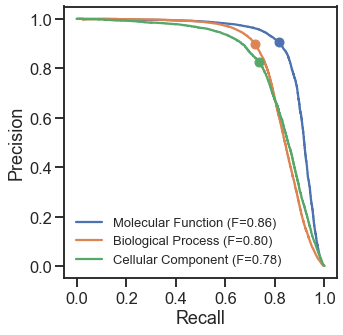

In [23]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, aspect='equal')


def get_fmax(precision, recall):
    fscores = (2 * precision * recall / (precision + recall))
    fmax = fscores.max()
    argmax = fscores.argmax()
    return fmax, argmax

fmax, argmax = get_fmax(precision_mf, recall_mf)
ax.plot(recall_mf, precision_mf, label=f'Molecular Function (F={fmax:.2f})', color=sns.color_palette()[0])
ax.plot(recall_mf[argmax], precision_mf[argmax], 'o', color=sns.color_palette()[0])

fmax, argmax = get_fmax(precision_bp, recall_bp)
ax.plot(recall_bp, precision_bp, label=f'Biological Process (F={fmax:.2f})', color=sns.color_palette()[1])
ax.plot(recall_bp[argmax], precision_bp[argmax], 'o', color=sns.color_palette()[1])

fmax, argmax = get_fmax(precision_cc, recall_cc)
ax.plot(recall_cc, precision_cc, label=f'Cellular Component (F={fmax:.2f})', color=sns.color_palette()[2])
ax.plot(recall_cc[argmax], precision_cc[argmax], 'o', color=sns.color_palette()[2])

ax.set_xticks(np.linspace(0, 1, 6, endpoint=True))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.legend(loc='lower left', fontsize=13)